# PDAC Calibration - 1y probability changes

Author: Sophie Wagner, sw3767@cumc.columbia.edu

## Packages, notebook preferences, etc.

In [1]:
# Required Packages
import numpy as np  # For matrix manipulation
import pandas as pd  # For output/input data processing
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps
from tqdm import tqdm
from datetime import datetime
import random 

# Add the src directory to the Python path
import sys
import os
sys.path.append(os.path.abspath('../src'))

# Load .py files
import common_functions as func
import calibration_plots as p
import configs as c
import gof

# Some aesthetic options
np.set_printoptions(suppress=True, linewidth=300, formatter={'float': '{: 0.9f}'.format})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Set up matrix

In [2]:
def row_normalize(matrix):
    
    for age_layer in range(matrix.shape[0]):
        layer = matrix[age_layer]
        non_diag_sum = np.sum(layer, axis=1) - np.diagonal(layer)

        # Scale rows if non-diagonal sum exceeds 1
        scaling_factors = np.clip(1 / non_diag_sum, None, 1)
        layer *= scaling_factors[:, np.newaxis]  # Scale entire rows

        # Adjust diagonal elements to ensure each row sums to 1
        np.fill_diagonal(layer, np.maximum(0, 1 - np.sum(layer, axis=1) + np.diagonal(layer)))

        # Update the matrix for the current age layer
        matrix[age_layer] = layer

    return matrix.clip(0.0, 1.0)

def create_matrix():
    
    matrix = np.zeros((len(c.age_layers), len(c.health_states_itos), len(c.health_states_itos)))
    age_50_idx = 6 if c.param_interval == 5 else 30
    matrix[:, 0, 1] = 1-(1-0.0011)**(1/25) # average risk after 50 ~ 0.0011, transformed to annual prob
    matrix[:age_50_idx, 0, 1] = np.linspace(0.000001,matrix[-1,0,1],age_50_idx)
    matrix[:, 1, 2] = 0.380016 # c.model_inputs_dict['p_Local_to_Regional_PC']  
    matrix[:, 2, 3] = 0.666632 # c.model_inputs_dict['p_Regional_to_Distant_PC']
    matrix[:, 1, 4] = 0.040325 # c.model_inputs_dict['p_symptom_local'] 
    matrix[:, 2, 5] = 0.328861 # c.model_inputs_dict['p_symptom_regional']
    matrix[:, 3, 6] = 0.332143 # c.model_inputs_dict['p_symptom_distant']
    
    matrix = add_acm(matrix)  # ACM
    matrix = add_csd(matrix)  # CSD
    matrix = constrain_matrix(matrix)  # constrain
    matrix = row_normalize(matrix)  # normalize

    return matrix


def constrain_matrix(matrix):
    
    matrix[:, 0, 1] = np.maximum(matrix[:,0,1], 0.0000001)
    # matrix[:, 0, 1] = np.maximum.accumulate(matrix[:, 0, 1])
    matrix[:, 1, 2] = np.maximum(matrix[:, 0, 1], matrix[:, 1, 2])
    matrix[:, 2, 3] = np.maximum(matrix[:, 1, 2], matrix[:, 2, 3])
    matrix[:, 2, 5] = np.maximum(matrix[:, 1, 4], matrix[:, 2, 5])
    matrix[:, 3, 6] = np.maximum(matrix[:, 2, 5], matrix[:, 3, 6])
    
    return matrix


def add_acm(matrix):
    
    # Note: c.acm_rates configured for either 1y or 5y acm
    matrix[:, :7, 8] = c.acm_rates[:, np.newaxis]
    matrix[:, 8, 8] = 1
    
    return matrix


def add_csd(matrix):  # Constant death rate in calibration
    
    matrix[:, 4, 7] = c.model_inputs_dict['p_local_death']
    matrix[:, 5, 7] = c.model_inputs_dict['p_regional_death']
    matrix[:, 6, 7] = c.model_inputs_dict['p_distant_death']
    matrix[:, 7, 7] = 1
    
    return matrix

## Markov model

In [3]:
def run_markov(matrix, starting_age=20, max_age=84):
    
    current_age = starting_age
    age_layer = 0
    month_pop, pop_log = c.starting_pop, c.starting_pop  # (13, 1)
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state
    matrixT = matrix.transpose(0,2,1)  # (13, 9, 9)
    inflow_matrix = np.tril(matrixT, k=-1)
    
    while current_age < max_age:            

        # Matrix multiplication (state transition)
        mat, inflow_mat = matrixT[age_layer], inflow_matrix[age_layer] 
        month_inc = np.matmul(inflow_mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
        month_pop = np.matmul(mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
         
        # Add to log
        inc_log = np.concatenate((inc_log, month_inc), axis=1)  # (13, 65)
        pop_log = np.concatenate((pop_log, month_pop), axis=1)  # (13, 65)
        
        current_age += 1
        if current_age in c.ages_1y:
            age_layer += 1
            
    incidence, incidence_unadj = inc_log.copy(), inc_log.copy()
    dead_factor = np.divide(c.N, c.N - pop_log[7:, :].sum(axis=0))  # inc and prev denominator is out of living only
    prevalence = np.zeros(pop_log.shape) 

    for state in range(9):
        incidence[state, :] = np.multiply(incidence[state, :], dead_factor)
        prevalence[state, :] = np.multiply(pop_log[state, :], dead_factor)

    return incidence, prevalence, incidence_unadj, pop_log

## Calibration

In [4]:
def step(matrix, step_size, num_adj=3):
    """
    Updates a parameter matrix, using reduced 5-y interval matrix (to reduce number of
    parameters to adjust, faster convergence, smoother parameter change). Randomly 
    selected transitions and age groups are adjusted by a scaled step size, then smoothed
    and interpolated to get yearly values.

    Args:
        matrix (numpy.ndarray): Full parameter matrix for all ages and transitions.
        step_size (float): Scale of parameter adjustments.
        num_adj (int): Number of parameters to modify.

    Returns:
        numpy.ndarray: Updated matrix with smoothed yearly transition probabilities.
    """
    points = list(c.transitions_itos.keys()) 
    step_tp = random.choices(points, k=num_adj)
    step_age = random.choices(c.age_layers_5y, k=num_adj)
    small_matrix = matrix[2::5, :, :]
    assert small_matrix.shape[0] == 13
    
    for i in range(num_adj):
        (from_state, to_state), age = step_tp[i], step_age[i]
        old_param = small_matrix[age, from_state, to_state] 
        step_param = (old_param * step_size).clip(0.00001, 0.1)
        small_matrix[age, from_state, to_state] += np.random.uniform(low=-step_param, high=step_param)

    new_matrix = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], small_matrix, axis=0, smooth=0.01)(c.ages_1y).clip(0.0,1.0)
    assert new_matrix.shape[0]==65
    
    new_matrix = add_acm(new_matrix)  # ACM
    new_matrix = add_csd(new_matrix)  # CSD
    new_matrix = constrain_matrix(new_matrix)  # constrain
    new_matrix = row_normalize(new_matrix)  # normalize

    return new_matrix

In [5]:
def progress_report(iteration, best_eval, best_log, ticker, best_t):
    """
    Prints progress report during simulated annealing.
    """
    log_adj, _, inc_log, _ = best_log
    total_dxd = np.sum(inc_log[4:7, :]) / c.N
    print(f"{iteration}: Best Eval: {best_eval:.5f}, PDAC: {total_dxd:.5f}, Tick: {ticker}")
    
    if iteration % 50000 == 0:
        transition_probs = p.extract_transition_probs(best_t, metric="avg")
        print(f"Detailed Progress Report, Iteration = {iteration}")
        print(transition_probs)
        p.plot_vs_seer(log_adj, c.seer_inc)

In [6]:
def simulated_annealing(n_iterations, step_size, start_tmat, n_adj=5, starting_temp=1, verbose=False, print_interval=1000):
    """
    Performs simulated annealing to optimize a transition matrix.

    Args:
        n_iterations (int): Number of iterations for optimization.
        step_size (float): Step size for parameter adjustments.
        start_tmat (numpy.ndarray): Initial transition matrix.
        n_adj (int): Number of parameters to adjust per step.
        starting_temp (float): Initial temperature for annealing.
        verbose (bool): Whether to print progress reports.
        print_interval (int): Interval for progress reporting.

    Returns:
        numpy.ndarray: Optimized transition matrix.
    """
    best_t = np.copy(start_tmat)
    best_log = run_markov(best_t)
    best_eval = gof.objective(best_log)
    curr_t, curr_eval = best_t, best_eval
    scheduler, ticker, iter_count = 0, 0, 0 

    with tqdm(total=n_iterations, desc="Simulated annealing progress", unit="iteration") as pbar:
        for i in range(n_iterations):
            # Generate candidate solution
            candidate_t = step(np.copy(curr_t), step_size, n_adj)
            candidate_log = run_markov(candidate_t)
            candidate_eval = gof.objective(candidate_log)

            # Update best solution
            if candidate_eval < best_eval:
                ticker, scheduler = 0, 0
                best_t, best_eval = np.copy(candidate_t), candidate_eval
                best_log = run_markov(best_t)

                # Dynamically adjust parameters on improvement
                step_size = max(0.9 * step_size, 0.075)  # Decay step size slightly
                starting_temp = max(0.95 * starting_temp, 1)  # Gradual cooling
                n_adj = max(2, n_adj - 1)  # Reduce number of adjustments for precision
                
                print(f"UPDATE ACCOMPLISHED at iteration {i}!")
                print(f"Best Eval: {best_eval} | Step Size: {step_size:.4f} | Temp: {starting_temp:.2f} | n_adj: {n_adj}")
                
            else:
                ticker += 1
                iter_count+=1
                scheduler+=1

            # Calculate temperature and Metropolis acceptance criterion
            t = starting_temp / (1 + 0.01 * np.sqrt(iter_count + 1))  # Adaptive cooling
            diff = candidate_eval - curr_eval
            metropolis = np.exp(-diff / t)

            if diff < 0 or np.random.random() < metropolis:
                curr_t, curr_eval = np.copy(candidate_t), candidate_eval

            # Print progress report
            if verbose and i > 0 and i % print_interval == 0:
                progress_report(i, best_eval, best_log, ticker, best_t)

            # Adjust or reset exploration parameters periodically
            if scheduler > 50000:  # Long stagnation
                step_size = np.random.uniform(0.1, 0.3)  # Randomize step size
                starting_temp = np.random.uniform(10, 50)  # Reset temperature
                n_adj = np.random.choice(range(1, 12))  # Random adjustments
                scheduler, iter_count = 0, 0, 0 # Reset 
            elif scheduler > 15000:  # Medium stagnation
                step_size = min(step_size + 0.05, 0.3)  # Increase step size for exploration
                starting_temp = min(starting_temp + 2, 50)  # Boost temperature for exploration
                n_adj = np.random.choice(range(3, 10))  # Randomize number of parameters to adjust
                scheduler, iter_count = 0, 0  # Reset stagnation counter

                
            pbar.update(1)

    print("Best evaluation:", best_eval)
    return best_t

## Run simulated annealing

In [7]:
def run_sa(tmat=None, save_all=False, n_iterations=50000, step_size=0.2, n_adj=5, starting_temp=1, print_interval=5000):
    
    start_tmat = None
    start_tmat = tmat if tmat is not None else create_matrix()   
    initial_score = gof.objective(run_markov(start_tmat))
    print(f"Initial score: {round(initial_score, 5)}")
    print("Starting calibration...")
    
    result = simulated_annealing(n_iterations=n_iterations, step_size=step_size, start_tmat=start_tmat, n_adj=n_adj, starting_temp=starting_temp, verbose=True, print_interval=print_interval)
    
    # Gather results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    curr_tmat = result.copy()
    curr_log = run_markov(curr_tmat)
    log_adj, log_prev, log_inc, pop_log = curr_log
    final_score = gof.objective(run_markov(curr_tmat))
    
    save = True if final_score < initial_score else save_all
    
    print("Done.")
    
    # Saving
    if save:
        log_path, tmat_path, plot_path = c.OUTPUT_PATHS["logs"], c.OUTPUT_PATHS["tmats"], c.OUTPUT_PATHS["plots"]
        np.save(f"{tmat_path}/{timestamp}_tmat.npy", curr_tmat)
        pd.DataFrame(log_adj).to_csv(f"{log_path}/{timestamp}_inc_adj.csv")
        pd.DataFrame(log_prev).to_csv(f"{log_path}/{timestamp}_prev.csv")
        pd.DataFrame(log_inc).to_csv(f"{log_path}/{timestamp}_inc_unadj.csv")
        pd.DataFrame(pop_log.T).to_csv(f"{log_path}/{timestamp}_pop_log.csv")
        p.plot_vs_seer(log_adj, c.seer_inc, save_imgs=True, show_plot=False, outpath=plot_path, timestamp=timestamp)
        p.plot_vs_seer_total(log_adj, c.seer_inc, save_imgs=True, show_plot=False, outpath=plot_path, timestamp=timestamp)

    return curr_tmat

In [10]:
result=np.load("../out/tmats/20241220_0826_tmat.npy")
for epoch in range(2):
    print(f"EPOCH {(epoch+1)}/2 ----------------------------------------------------------")
    result = run_sa(tmat=result, save_all=True, n_iterations=100000, step_size=0.2, n_adj=3, starting_temp=10)

EPOCH 1/2 ----------------------------------------------------------
Initial score: 278.47847
Starting calibration...


Simulated annealing progress:   0%|          | 0/100000 [00:00<?, ?iteration/s]

C:\Users\sophi\AppData\Local\Temp\ipykernel_36508\1146651065.py:8: RuntimeWarning: divide by zero encountered in divide
  scaling_factors = np.clip(1 / non_diag_sum, None, 1)
Simulated annealing progress:   0%|          | 177/100000 [00:02<23:35, 70.51iteration/s]

UPDATE ACCOMPLISHED at iteration 169!
Best Eval: 271.54956866076225 | Step Size: 0.1800 | Temp: 9.50 | n_adj: 2


Simulated annealing progress:   5%|▌         | 5054/100000 [00:21<05:23, 293.47iteration/s]

5000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 4831


Simulated annealing progress:  10%|█         | 10050/100000 [00:39<05:06, 293.39iteration/s]

10000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 9831


Simulated annealing progress:  15%|█▌        | 15040/100000 [00:56<04:41, 301.79iteration/s]

15000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 14831


Simulated annealing progress:  20%|██        | 20037/100000 [01:14<04:51, 274.11iteration/s]

20000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 19831


Simulated annealing progress:  25%|██▌       | 25051/100000 [01:31<04:16, 292.28iteration/s]

25000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 24831


Simulated annealing progress:  30%|███       | 30023/100000 [01:50<04:00, 290.42iteration/s]

30000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 29831


Simulated annealing progress:  35%|███▌      | 35042/100000 [02:07<03:48, 284.63iteration/s]

35000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 34831


Simulated annealing progress:  40%|████      | 40047/100000 [02:24<03:19, 300.66iteration/s]

40000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 39831


Simulated annealing progress:  45%|████▌     | 45047/100000 [02:41<03:04, 298.21iteration/s]

45000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 44831


Simulated annealing progress:  50%|████▉     | 49978/100000 [02:58<02:51, 291.70iteration/s]C:\Users\sophi\AppData\Local\Temp\ipykernel_36508\1146651065.py:8: RuntimeWarning: divide by zero encountered in divide
  scaling_factors = np.clip(1 / non_diag_sum, None, 1)
Simulated annealing progress:  50%|█████     | 50008/100000 [02:59<03:39, 227.27iteration/s]

50000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 49831
Detailed Progress Report, Iteration = 50000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00000  0.00042  0.00000  0.00048  0.00020
1  u_PDAC_loc  u_PDAC_reg  0.14717  0.21312  0.12967  0.21644  0.18344
2  u_PDAC_reg  u_PDAC_dis  0.29677  0.51465  0.22492  0.53528  0.40640
3  u_PDAC_loc  d_PDAC_loc  0.02195  0.02043  0.01904  0.02207  0.02056
4  u_PDAC_reg  d_PDAC_reg  0.28740  0.26894  0.26434  0.29014  0.27599
5  u_PDAC_dis  d_PDAC_dis  0.53833  0.51693  0.51666  0.54660  0.52787


Simulated annealing progress:  55%|█████▌    | 55055/100000 [03:16<02:35, 289.80iteration/s]

55000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 54831


Simulated annealing progress:  60%|██████    | 60048/100000 [03:34<02:18, 288.68iteration/s]

60000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 59831


Simulated annealing progress:  65%|██████▌   | 65027/100000 [03:51<01:57, 296.81iteration/s]

65000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 64831


Simulated annealing progress:  70%|███████   | 70061/100000 [04:09<01:44, 286.18iteration/s]

70000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 69831


Simulated annealing progress:  75%|███████▌  | 75048/100000 [04:26<01:25, 292.56iteration/s]

75000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 74831


Simulated annealing progress:  80%|████████  | 80031/100000 [04:43<01:07, 294.70iteration/s]

80000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 79831


Simulated annealing progress:  85%|████████▌ | 85051/100000 [05:00<00:51, 291.85iteration/s]

85000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 84831


Simulated annealing progress:  90%|█████████ | 90047/100000 [05:18<00:33, 299.26iteration/s]

90000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 89831


Simulated annealing progress:  95%|█████████▌| 95047/100000 [05:36<00:17, 289.05iteration/s]

95000: Best Eval: 271.54957, PDAC: 0.00713, Tick: 94831


Simulated annealing progress: 100%|██████████| 100000/100000 [05:53<00:00, 282.79iteration/s]


Best evaluation: 271.54956866076225
Done.
EPOCH 2/2 ----------------------------------------------------------
Initial score: 271.54957
Starting calibration...


Simulated annealing progress:   1%|          | 650/100000 [00:02<05:45, 287.62iteration/s]

UPDATE ACCOMPLISHED at iteration 600!
Best Eval: 252.41166854239506 | Step Size: 0.1800 | Temp: 9.50 | n_adj: 2
UPDATE ACCOMPLISHED at iteration 602!
Best Eval: 252.2148593437704 | Step Size: 0.1620 | Temp: 9.03 | n_adj: 2


Simulated annealing progress:   5%|▌         | 5020/100000 [00:17<08:39, 182.77iteration/s]

5000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 4398


Simulated annealing progress:  10%|█         | 10053/100000 [00:36<05:10, 290.09iteration/s]

10000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 9398


Simulated annealing progress:  15%|█▌        | 15039/100000 [00:55<04:45, 297.91iteration/s]

15000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 14398


Simulated annealing progress:  20%|██        | 20032/100000 [01:12<04:47, 278.13iteration/s]

20000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 19398


Simulated annealing progress:  25%|██▌       | 25057/100000 [01:30<04:14, 294.90iteration/s]

25000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 24398


Simulated annealing progress:  30%|███       | 30031/100000 [01:50<04:10, 279.03iteration/s]

30000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 29398


Simulated annealing progress:  35%|███▌      | 35038/100000 [02:06<03:37, 298.71iteration/s]

35000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 34398


Simulated annealing progress:  40%|████      | 40047/100000 [02:23<03:21, 298.12iteration/s]

40000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 39398


Simulated annealing progress:  45%|████▌     | 45053/100000 [02:40<03:04, 297.44iteration/s]

45000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 44398


Simulated annealing progress:  50%|████▉     | 49981/100000 [02:59<03:09, 264.07iteration/s]C:\Users\sophi\AppData\Local\Temp\ipykernel_36508\1146651065.py:8: RuntimeWarning: divide by zero encountered in divide
  scaling_factors = np.clip(1 / non_diag_sum, None, 1)
Simulated annealing progress:  50%|█████     | 50039/100000 [02:59<03:04, 271.27iteration/s]

50000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 49398
Detailed Progress Report, Iteration = 50000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00000  0.00044  0.00000  0.00049  0.00020
1  u_PDAC_loc  u_PDAC_reg  0.14007  0.21082  0.12057  0.21736  0.17716
2  u_PDAC_reg  u_PDAC_dis  0.27514  0.49974  0.21804  0.52762  0.39383
3  u_PDAC_loc  d_PDAC_loc  0.02205  0.02026  0.01949  0.02288  0.02075
4  u_PDAC_reg  d_PDAC_reg  0.29325  0.25908  0.24810  0.29334  0.27040
5  u_PDAC_dis  d_PDAC_dis  0.54205  0.51844  0.51606  0.54799  0.52995


Simulated annealing progress:  55%|█████▌    | 55064/100000 [03:17<02:30, 298.65iteration/s]

55000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 54398


Simulated annealing progress:  60%|██████    | 60048/100000 [03:34<02:14, 297.03iteration/s]

60000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 59398


Simulated annealing progress:  65%|██████▌   | 65059/100000 [03:51<01:56, 300.68iteration/s]

65000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 64398


Simulated annealing progress:  70%|███████   | 70017/100000 [04:08<01:43, 290.87iteration/s]

70000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 69398


Simulated annealing progress:  75%|███████▌  | 75051/100000 [04:25<01:22, 304.06iteration/s]

75000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 74398


Simulated annealing progress:  80%|████████  | 80060/100000 [04:42<01:08, 289.28iteration/s]

80000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 79398


Simulated annealing progress:  85%|████████▌ | 85038/100000 [04:58<00:49, 300.27iteration/s]

85000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 84398


Simulated annealing progress:  90%|█████████ | 90040/100000 [05:15<00:32, 307.76iteration/s]

90000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 89398


Simulated annealing progress:  95%|█████████▌| 95041/100000 [05:32<00:16, 304.87iteration/s]

95000: Best Eval: 252.21486, PDAC: 0.00721, Tick: 94398


Simulated annealing progress: 100%|██████████| 100000/100000 [05:49<00:00, 285.85iteration/s]


Best evaluation: 252.2148593437704
Done.


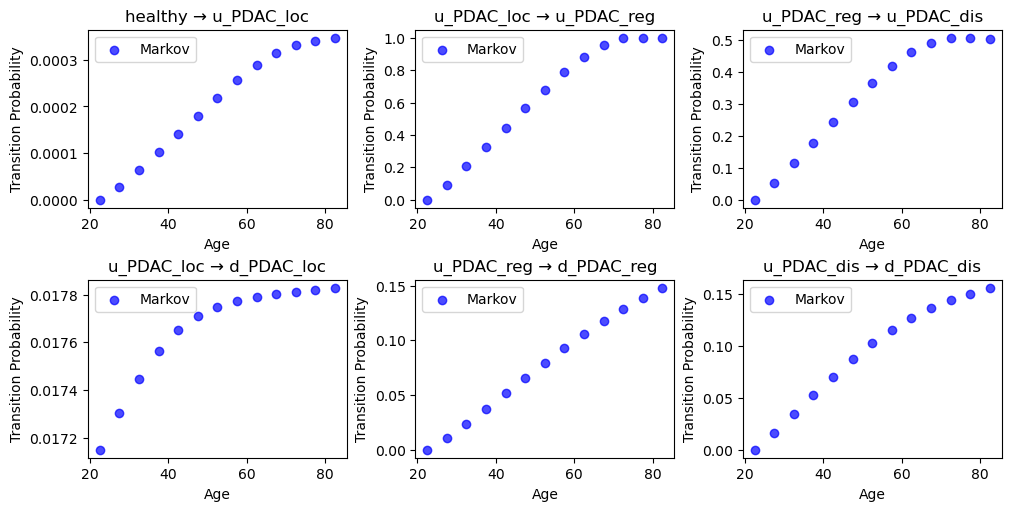

In [160]:
tmat = np.load("../out/tmats/20241219_1748_tmat.npy")
p.plot_params(tmat, show_plot=True)

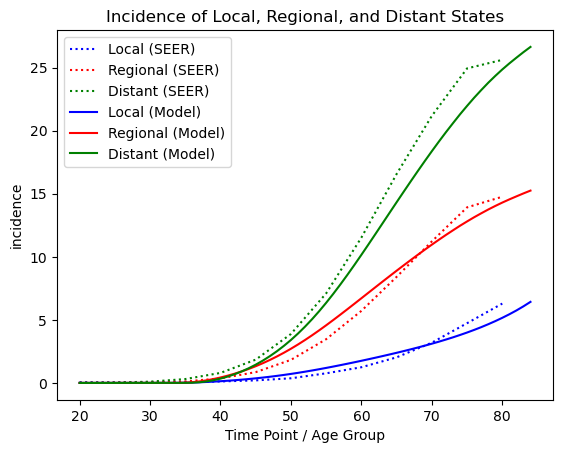

In [158]:
temp = tmat.copy()

# Healthy to local
temp[:30, 0, 1] *= 0.2
temp[30:, 0, 1] *= 1.2
temp[50:, 0, 1] *= 1.4

# Loc to Reg
temp[:, 1, 2] = 0.2
temp[50:, 1, 2] = np.linspace(0.2, 0.05, 15)

# Reg to Dis
temp[:, 2, 3] = 0.45
temp[25:35, 2, 3] = np.linspace(0.45, 0.55, 10)
temp[35:, 2, 3] = 0.55
temp[50:, 2, 3] = np.linspace(0.55, 0.5, 15)

# Detection
temp[:, 2, 5] = 0.3
temp[:, 3, 6] = 0.50

temp = temp[::5,:,:]
tmat_smoothed = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], temp, axis=0, smooth=0.001)(c.ages_1y)
tmat_smoothed = add_acm(tmat_smoothed)
tmat_smoothed = add_csd(tmat_smoothed)
tmat_smoothed = constrain_matrix(tmat_smoothed)
tmat_smoothed = row_normalize(tmat_smoothed)
p.plot_vs_seer(run_markov(tmat_smoothed)[0], c.seer_inc, show_plot=True)

In [159]:
np.save("../out/tmats/20241219_2250.npy", tmat_smoothed)

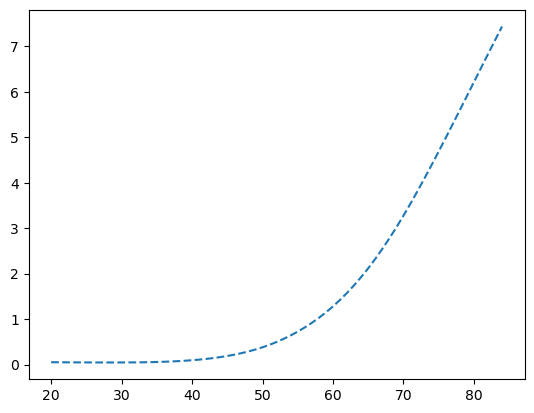

In [56]:
smooth=csaps(c.ages_5y, c.seer_inc_5y['LocalU'], smooth=0.01)(c.ages_1y)
plt.plot(c.ages_1y, smooth, linestyle="--")

In [17]:
tmat=np.load("../out/tmats/20241219_2250_tmat.npy")

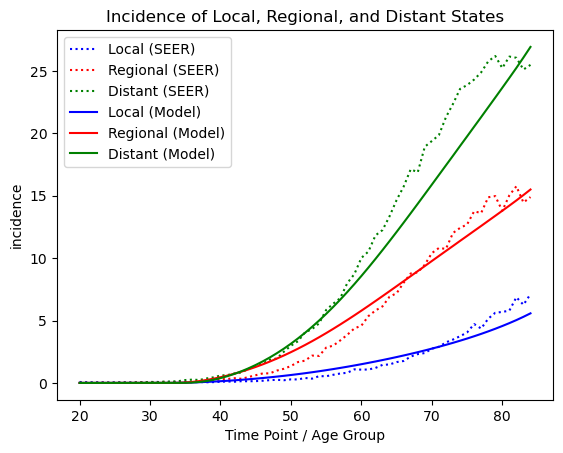

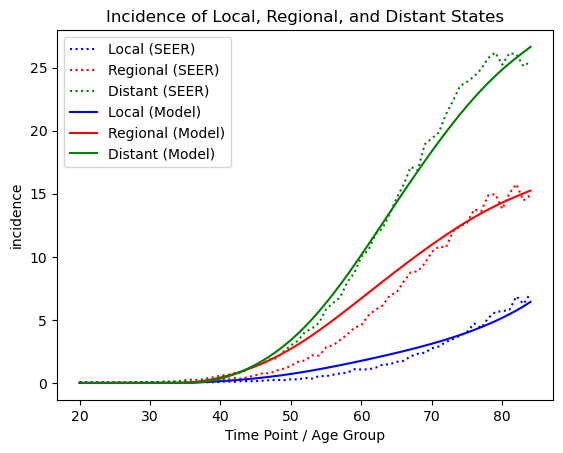

In [19]:
temp = tmat[::5,:,:].copy()
tmat_smoothed = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], temp, axis=0, smooth=0.001)(c.ages_1y)
tmat_smoothed = add_acm(tmat_smoothed)
tmat_smoothed = add_csd(tmat_smoothed)
tmat_smoothed = constrain_matrix(tmat_smoothed)
tmat_smoothed = row_normalize(tmat_smoothed)
p.plot_vs_seer(run_markov(tmat_smoothed)[0], c.seer_inc, show_plot=True)
p.plot_vs_seer(run_markov(tmat)[0], c.seer_inc, show_plot=True)

In [ ]:
np.save("../out/tmats/20241220_0723_tmat.npy", tmat_smoothed)

## Post-processing

In [28]:
def smooth_tmat(mat, save=False, outpath=c.OUTPUT_PATHS['tmats'], timestamp=""): # (sex: 2, race: 2, age_buckets: 10, state: 18, state: 18)
    
    # Anchor with mean at 100 and Smooth interpolation over age
    tmat_anchored = np.concatenate([mat, np.minimum(mat[-1:, :, :], np.mean(mat, axis=0, keepdims=True))], axis=0) # take mean of values over age buckets and set at age 100 (only if mean lower than last age bucket)
    tmat = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5], mat, smooth=0.01, axis=0)(np.linspace(20,100,81)) # interpolation without anchoring
    tmat_anchored = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5,100], tmat_anchored, smooth=0.01, axis=0)(np.linspace(20,100,81)).clip(0.0, 1.0)

    # If smoothed tmat is exp increasing towards end, used anchored probs
    increasing_at_100 = tmat[-2:-1, :, :] < tmat[-1:, :, :]
    tmat_anchored = np.where(increasing_at_100, tmat_anchored, tmat)
    transition_mask = np.zeros((13, 13), dtype=bool)
    from_states, to_states= c.transitions_itos.keys()
    transition_mask[from_states, to_states] = True
    tmat_anchored = np.where(increasing_at_100 & transition_mask[np.newaxis, ...], tmat_anchored, tmat)

    tmat = tmat_anchored
    tmat = row_normalize(tmat)

    if save:
      os.makedirs(outpath, exist_ok=True)
      name = f"tmat_{timestamp}"
      np.save(f"{outpath}/{name}.npy", tmat)
      
    return tmat

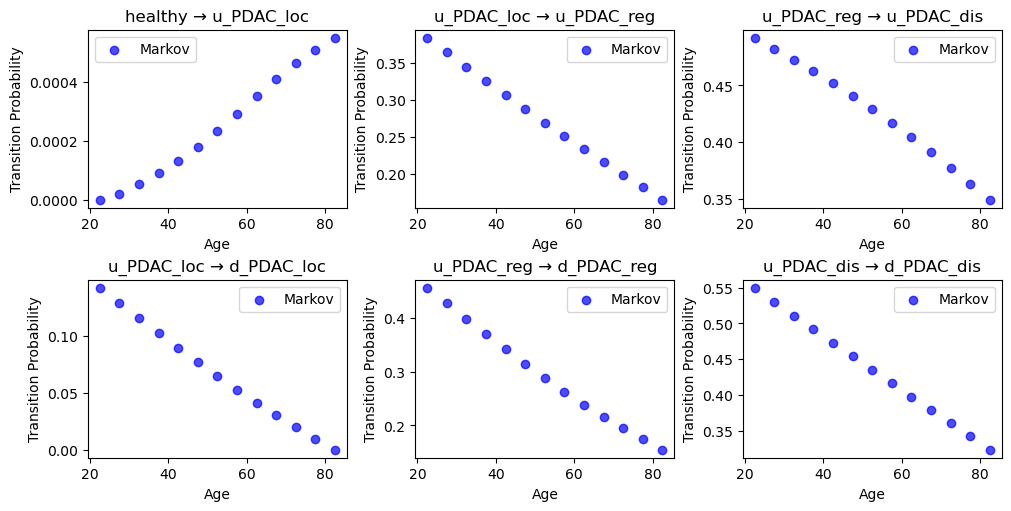

In [31]:
p.plot_params(result, show_plot=True)
markov_tmat = result
treeage_tmat = smooth_tmat(markov_tmat, save=False, timestamp="20241218_1605")
p.plot_params(markov_tmat, treeage_tmat, save_imgs=False, show_plot=True)